In [9]:
# Import libraries and data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/alzheimers.csv')

In [2]:
# Define function for model comparison

def collect_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [3]:
# Prepare data for model fitting

# Assume df is your cleaned DataFrame and 'HeartDisease' is the target
X = df.drop('Diagnosis', axis=1)
X = X.drop('PatientID', axis=1)
X = X.drop('DoctorInCharge', axis=1)
y = df['Diagnosis']

# One-hot encoding if needed
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Hyper-parameter tuning using grid search

# Define data pipeline and parameter grid
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (100, 50), (150, 75),
        (100, 50, 25)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'solver': ['adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [5000]
}

ann = MLPClassifier(random_state=49)

grid_search = GridSearchCV(
    ann,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# Use best estimator
best_ann = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0001, 'max_iter': 5000, 'solver': 'adam'}
Best F1 Score: 0.7718699630496527


In [5]:
# Fit model using test train split

metrics_list = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
best_ann.fit(X_train, y_train)
y_pred = best_ann.predict(X_test)

metrics_list.append(collect_metrics(y_test, y_pred, method_name='Train/Test Split'))

In [6]:
# Fit model using K-fold

skf = StratifiedKFold(n_splits=10)
y_true_all, y_pred_all = [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    best_ann.fit(X_train, y_train)
    y_pred = best_ann.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

metrics_list.append(collect_metrics(y_true_all, y_pred_all, method_name='Stratified K-Fold'))

In [7]:
# Compare model performance

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

              method  accuracy  precision    recall  f1_score
0   Train/Test Split  0.855814   0.804054  0.782895  0.793333
1  Stratified K-Fold  0.844579   0.831776  0.702632  0.761769


                        Accuracy  Precision    Recall  F1 Score   ROC AUC
ANN - Train/Test Split  0.855814   0.804054  0.782895  0.793333  0.923608


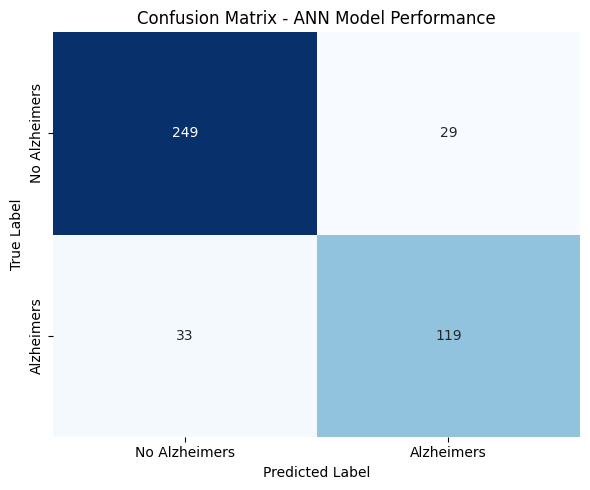

In [10]:
# Re-fit the test/train model and report performance metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
best_ann.fit(X_train, y_train)
y_pred = best_ann.predict(X_test)

# Predict using the trained ANN model from Train/Test Split
y_pred = best_ann.predict(X_test)
y_proba = best_ann.predict_proba(X_test)[:, 1]  # Needed for ROC AUC

# Collect performance metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics, index=['ANN - Train/Test Split'])
print(metrics_df)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['No Alzheimers', 'Alzheimers']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ANN Model Performance')
plt.tight_layout()
plt.show()